In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F

In [2]:
data_directory = '../data'

# Get all CSV files in the raw folder
all_files = glob.glob(os.path.join(data_directory+'/raw', 'raw_*.csv'))
# Read and concatenate all files
df_raw = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
# Create a new session_id column using integer division
df_raw['session_id'] = df_raw.index // 256 + 1
# Reset timestamp to go from 1-256 and reset back to 1 for each session
df_raw['timestamp'] = df_raw.groupby('session_id').cumcount() + 1

# Get all CSV files in the pbb folder
all_files = glob.glob(os.path.join(data_directory+'/pbb', 'power_by_band_*.csv'))
# Read and concatenate all files
df_pbb = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
# Create a new session_id column using integer division
df_pbb['session_id'] = df_pbb.index // 4 + 1
# Reset timestamp to go from 1-4 and reset back to 1 for each session
df_pbb['timestamp'] = df_pbb.groupby('session_id').cumcount() + 1

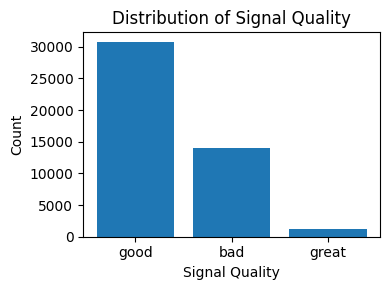

In [3]:
# Count the occurrences of each signal quality value
signal_quality_counts = df_pbb['Signal_Quality'].value_counts()

# Create a bar plot
plt.figure(figsize=(4, 3))
plt.bar(signal_quality_counts.index, signal_quality_counts.values)
plt.title('Distribution of Signal Quality')
plt.xlabel('Signal Quality')
plt.ylabel('Count')

plt.tight_layout()

In [4]:
df_raw = df_raw.drop(['participantName', 'Signal_Quality'], axis=1)
df_pbb = df_pbb.drop(['participantName', 'Signal_Quality'], axis=1)

In [8]:
print(f"Shape of df_raw: {df_raw.shape}")
print(f"Shape of df_pbb: {df_pbb.shape}")

Shape of df_raw: (159866458, 11)
Shape of df_pbb: (45856, 27)


In [9]:
df_pbb.head()

,session_id,timestamp,alpha_0,alpha_1,alpha_2,alpha_3,alpha_4,alpha_5,alpha_6,alpha_7,...,beta_7,gamma_0,gamma_1,gamma_2,gamma_3,gamma_4,gamma_5,gamma_6,gamma_7,frequency
0,1,1,4.275338,1.140815,1.850872,11.234104,12.738430,0.972481,1.981474,15.041341,...,6.496207,0.845900,0.377735,0.416358,0.899955,0.861396,0.460077,0.291946,1.276625,10
1,1,2,2.784938,1.255267,1.331556,5.504202,6.290838,2.647313,1.758902,7.987278,...,9.164653,0.720075,0.334263,0.448752,0.795720,0.795825,0.415482,0.237792,1.202401,10
2,1,3,8.048137,0.628478,1.271079,15.042143,12.915017,3.169237,2.786298,11.464602,...,5.511734,0.706239,0.330959,0.438001,1.113344,1.104862,0.366313,0.171121,1.504819,10
3,1,4,4.963768,1.371590,2.340502,9.598443,10.389605,1.529685,1.755190,6.439778,...,6.390969,0.962401,0.314345,0.392416,1.374240,1.279771,0.295123,0.190873,1.449422,10
4,2,1,2.784938,1.255267,1.331556,5.504202,6.290838,2.647313,1.758902,7.987278,...,9.164653,0.720075,0.334263,0.448752,0.795720,0.795825,0.415482,0.237792,1.202401,10


In [20]:
from tqdm import tqdm

# Get unique session IDs
unique_sessions = df_raw['session_id'].unique()

# Initialize lists to store features and targets
X = []
y = []

# For each session, create a 2D matrix
for session in tqdm(unique_sessions, desc="Processing sessions"):
    # Get data for this session
    session_data = df_raw[df_raw['session_id'] == session]
    # session_data_pbb = df_pbb[df_pbb['session_id'] == session]
    
    # if session_data['frequency'].iloc[0] != session_data['frequency'].iloc[0]:
    #     print(f"Frequency mismatch in session {session}")
    #     continue
    
    # Remove session_id, timestamp and frequency columns for feature matrix
    feature_cols = [col for col in df_raw.columns if col not in ['session_id', 'frequency']]
    
    # Create 2D matrix of features
    session_matrix = session_data[feature_cols].values
    
    # Adding alpha values
    # alpha_cols = [col for col in session_data_pbb.columns if 'alpha' in col or col == 'timestamp']
    # alpha_matrix = session_data_pbb[alpha_cols].values
    
    # Adding beta values
    # beta_cols = [col for col in session_data_pbb.columns if 'beta' in col or col == 'timestamp']
    # beta_matrix = session_data_pbb[beta_cols].values
    
    # Adding gamma values
    # gamma_cols = [col for col in session_data_pbb.columns if 'gamma' in col or col == 'timestamp']
    # gamma_matrix = session_data_pbb[gamma_cols].values
    
    # Combining all matrices
    # session_matrix
    
    # Get the frequency value (should be same for all rows in session)
    frequency = session_data['frequency'].iloc[0]
    
    X.append(session_matrix)
    y.append(frequency)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Input shape: {X.shape}")  # Should be (n_sessions, 4, 24)
print(f"Target shape: {y.shape}")  # Should be (n_sessions,)

Processing sessions:   0%|          | 80/624479 [00:13<30:17:39,  5.73it/s]


KeyboardInterrupt: 

# Parallelized

In [21]:
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import numpy as np

# Function to process each session
def process_session(session):
    try:
        # Get data for this session
        session_data = df_raw[df_raw['session_id'] == session]
        # session_data_pbb = df_pbb[df_pbb['session_id'] == session]
        
        # Check for frequency mismatch
        # if session_data['frequency'].iloc[0] != session_data['frequency'].iloc[0]:
        #     print(f"Frequency mismatch in session {session}")
        #     return None, None
        
        # Remove session_id, timestamp, and frequency columns for feature matrix
        feature_cols = [col for col in df_raw.columns if col not in ['session_id', 'frequency']]
        
        # Create 2D matrix (4 timestamps x 24 features)
        session_matrix = session_data[feature_cols].values
        
        # Adding alpha values
        # alpha_cols = [col for col in session_data_pbb.columns if 'alpha' in col or col == 'timestamp']
        # alpha_matrix = session_data_pbb[alpha_cols].values
        
        # Adding beta values
        # beta_cols = [col for col in session_data_pbb.columns if 'beta' in col or col == 'timestamp']
        # beta_matrix = session_data_pbb[beta_cols].values
        
        # Adding gamma values
        # gamma_cols = [col for col in session_data_pbb.columns if 'gamma' in col or col == 'timestamp']
        # gamma_matrix = session_data_pbb[gamma_cols].values
        
        # Combining all matrices
        # session_matrix = np.vstack([session_matrix, alpha_matrix, beta_matrix, gamma_matrix])
        
        # Get the frequency value (should be the same for all rows in session)
        frequency = session_data['frequency'].iloc[0]
        
        return session_matrix, frequency
    except Exception as e:
        print(f"Error processing session {session}: {e}")
        return None, None

# Get unique session IDs
unique_sessions = df_raw['session_id'].unique()

# Use multiprocessing Pool to parallelize
with Pool(cpu_count()) as pool:
    results = list(tqdm(pool.imap(process_session, unique_sessions), total=len(unique_sessions), desc="Processing sessions"))

# Collect results
X = [result[0] for result in results if result[0] is not None]
y = [result[1] for result in results if result[1] is not None]

Processing sessions: 100%|██████████| 624479/624479 [1:12:41<00:00, 143.17it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (624479,) + inhomogeneous part.

In [ ]:
# Convert to numpy arrays
X = np.array(X[:624478])
y = np.array(y[:624478])

print(f"Input shape: {X.shape}") 
print(f"Target shape: {y.shape}") 

Input shape: (624478, 256, 9)
Target shape: (624478,)


# Pickle X and y

In [29]:
import pickle
import os

# Create pickles directory if it doesn't exist
os.makedirs('../data/pickles', exist_ok=True)

# Save X and y to pickle files
with open('../data/pickles/X.pkl', 'wb') as f:
    pickle.dump(X, f)
    
with open('../data/pickles/y.pkl', 'wb') as f:
    pickle.dump(y, f)

print("Data saved to pickle files in ../data/pickles/")

Data saved to pickle files in ../data/pickles/


## Load X and y

In [30]:
import pickle

# Load X and y from pickle files
with open('../data/pickles/X.pkl', 'rb') as f:
    X = pickle.load(f)
    
with open('../data/pickles/y.pkl', 'rb') as f:
    y = pickle.load(f)

print(f"Loaded X shape: {X.shape}")
print(f"Loaded y shape: {y.shape}")

Loaded X shape: (624478, 256, 9)
Loaded y shape: (624478,)


In [31]:
# Encode the target labels (frequencies)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert data to tensors and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = torch.FloatTensor(X)
y_encoded = torch.LongTensor(y_encoded)

# Transpose input to match expected shape (batch_size, channels, sequence_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train = X_train.transpose(1, 2)
X_test = X_test.transpose(1, 2)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: torch.Size([499582, 9, 256])
Shape of X_test: torch.Size([124896, 9, 256])
Shape of y_train: torch.Size([499582])
Shape of y_test: torch.Size([124896])


Epoch [1/200], Loss: 1.2989
Epoch [2/200], Loss: 1.2170
Epoch [3/200], Loss: 1.1655
Epoch [4/200], Loss: 1.1286
Epoch [5/200], Loss: 1.0974
Epoch [6/200], Loss: 1.0679
Epoch [7/200], Loss: 1.0405
Epoch [8/200], Loss: 1.0183
Epoch [9/200], Loss: 0.9951
Epoch [10/200], Loss: 0.9774
Epoch [11/200], Loss: 0.9575
Epoch [12/200], Loss: 0.9395
Epoch [13/200], Loss: 0.9214
Epoch [14/200], Loss: 0.9044
Epoch [15/200], Loss: 0.8881
Epoch [16/200], Loss: 0.8713
Epoch [17/200], Loss: 0.8563
Epoch [18/200], Loss: 0.8424
Epoch [19/200], Loss: 0.8270
Epoch [20/200], Loss: 0.8163
Epoch [21/200], Loss: 0.8033
Epoch [22/200], Loss: 0.7898
Epoch [23/200], Loss: 0.7783
Epoch [24/200], Loss: 0.7692
Epoch [25/200], Loss: 0.7582
Epoch [26/200], Loss: 0.7481
Epoch [27/200], Loss: 0.7406
Epoch [28/200], Loss: 0.7287
Epoch [29/200], Loss: 0.7228
Epoch [30/200], Loss: 0.7115
Epoch [31/200], Loss: 0.7068
Epoch [32/200], Loss: 0.6981
Epoch [33/200], Loss: 0.6911
Epoch [34/200], Loss: 0.6865
Epoch [35/200], Loss: 0

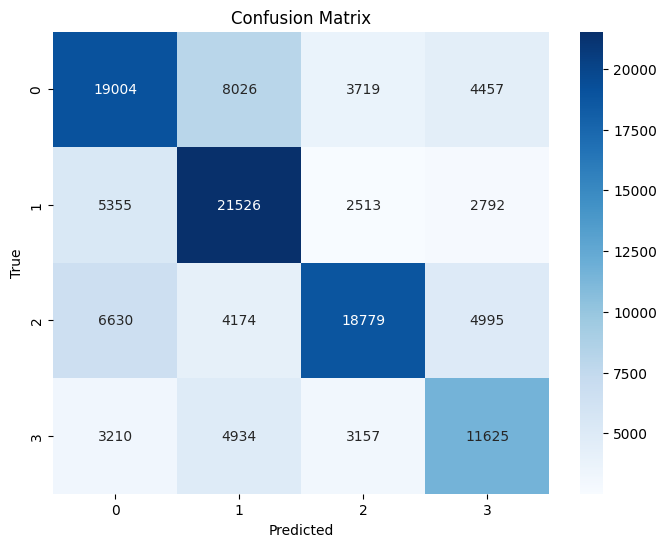

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv1d(9, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Third convolutional block
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fourth convolutional block
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 16, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)
        
        # Regularization
        self.dropout = nn.Dropout(p=0.5)
        
        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # First conv block
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout(x)
        
        # Second conv block
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(x)
        
        # Third conv block
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout(x)
        
        # Fourth conv block
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout(x)
        
        # Fully connected layers
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# Initialize model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 200
batch_size = 64

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
train_losses = []
best_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_epoch_loss = epoch_loss / num_batches
    train_losses.append(avg_epoch_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
    
    # Save best model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        best_model_state = model.state_dict().copy()

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device))
    y_pred_classes = torch.argmax(y_pred, dim=1).cpu().numpy()
    
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test.cpu().numpy(), y_pred_classes))

# Create confusion matrix
cm = confusion_matrix(y_test.cpu().numpy(), y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()